# Visualize the camera and gelsight poses in the dataset
Given the tracking data and calibration results, we project the camera and the gelsight sensor in the world coordinate frame, together with the object

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pytorch3d.transforms as transformations
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))
from utils.utils import *
import os.path as osp
import random
from datetime import datetime

In [2]:
from utils.camera_pose_visualizer import CameraPoseVisualizer

## Set data directory

In [3]:
# set the project directory and object dataset directory
parent_dir = os.path.dirname(os.getcwd())
obj_name = "woodbox_20240112_obj_frame" # "dumbbell_20231207_obj_frame"
obj_dir = osp.join(parent_dir, 'data', obj_name)
print(f"parent_dir: {parent_dir} \nobj_dir: {obj_dir}")

parent_dir: /data/ruihan/projects/NeRF-Texture 
obj_dir: /data/ruihan/projects/NeRF-Texture/data/woodbox_20240112_obj_frame


### Visualize poses in images.txt  (Before generating .json file)

In [12]:
def visualize_cam_gelsight_poses_3D(T_camerainworld=None, T_gelsightinworld=None, plt_title="Visualize cameras in world frame", save_plot=False, show_plot=True, save_path=None, dpi=600, flip_transform=np.eye(4), focal_len_scaled=0.1, draw_idx=False, selected_idx=None):
    """
    """
    # Create 3D plot for visualization
    axis_margin = 0.01
    
    if T_camerainworld is not None:
        if len(T_camerainworld.shape) == 2:
            T_camerainworld = np.expand_dims(T_camerainworld, axis=0)
        T_camerainworld = T_camerainworld @ flip_transform
        print(f"Visualize {len(T_camerainworld)} camera poses in world frame")
    
    if T_gelsightinworld is not None:
        if len(T_gelsightinworld.shape) == 2:
            T_gelsightinworld = np.expand_dims(T_gelsightinworld, axis=0)
        T_gelsightinworld = T_gelsightinworld @ flip_transform
        print(f"Visualize {len(T_gelsightinworld)} gelsight poses in world frame")
    
    # obtain the min and max of all camera poses
    # assume the camera poses occupy a larger space than the gelsight poses
    if T_camerainworld is not None:
        T_limit = T_camerainworld
    else:
        assert T_gelsightinworld is not None, "Please provide either T_camerainworld or T_gelsightinworld"
        T_limit = T_gelsightinworld

    x_min = np.min(T_limit[:, 0, 3]) - axis_margin
    x_max = np.max(T_limit[:, 0, 3]) + axis_margin
    y_min = np.min(T_limit[:, 1, 3]) - axis_margin
    y_max = np.max(T_limit[:, 1, 3]) + axis_margin
    z_min = np.min(T_limit[:, 2, 3]) - axis_margin
    z_max = np.max(T_limit[:, 2, 3]) + axis_margin
    print(f"limit for all sensor poses: x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}, z_min: {z_min}, z_max: {z_max}")

    visualizer = CameraPoseVisualizer([x_min, x_max], [y_min, y_max], [z_min, z_max])
    set_axes_equal(visualizer.ax)

    if T_camerainworld is not None:
        # Add camera poses in the world
        cam_colormap = plt.get_cmap("autumn")
        num_colors = len(T_camerainworld)
        colors = [cam_colormap(i / num_colors) for i in range(num_colors)]
        # Add camera poses in the world
        for i, color in zip(range(len(T_camerainworld)), colors):
            if selected_idx is not None and i not in selected_idx:
                continue
            visualizer.extrinsic2pyramid(T_camerainworld[i], color, focal_len_scaled=focal_len_scaled, idx=i, draw_idx=draw_idx)
    
    if T_gelsightinworld is not None:
        # Add gelsight poses in the world
        gelsight_colormap = plt.get_cmap("winter")
        num_colors = len(T_gelsightinworld)
        colors = [gelsight_colormap(i / num_colors) for i in range(num_colors)]
        # Add camera poses in the world
        for i, color in zip(range(len(T_gelsightinworld)), colors):
            visualizer.extrinsic2pyramid(T_gelsightinworld[i], color, focal_len_scaled=focal_len_scaled/2, idx=i)
    
    visualizer.show(plt_title=plt_title, save_plot=save_plot, show_plot=show_plot, save_path=save_path, dpi=dpi)

Visualize 302 camera poses in world frame
Visualize 111 gelsight poses in world frame
limit for all camera poses: x_min: -0.5643722489652823, x_max: 0.583071901046112, y_min: -0.5532568586800239, y_max: 0.5941502125444991, z_min: 0.055066012367580734, z_max: 0.3712863678110504
initialize camera pose visualizer
Save plot to logs/visualize_cam_gelsight_poses_txt_woodbox_20240112_obj_frame.png


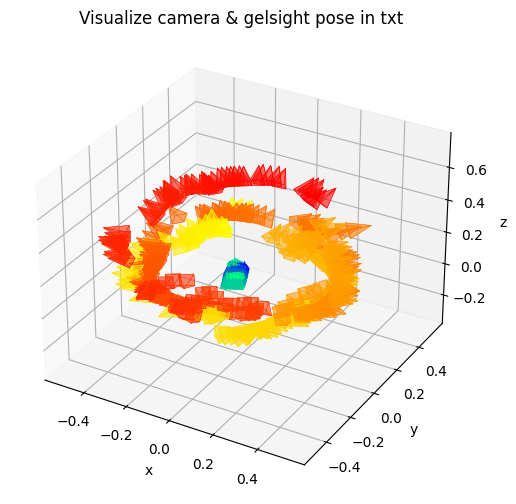

In [5]:
# Read images.txt and extract the camera poses
T_camerainworld = []
images_txt_path = osp.join(obj_dir, 'images_all.txt')
with open(images_txt_path) as f:
    images_txt = f.readlines()
    images_txt = [x.strip() for x in images_txt]
    for i in range(len(images_txt)):
        if images_txt[i].startswith('#'):
            continue
        img_id, qw, qx, qy, qz, tx, ty, tz, cam_id, img_name = images_txt[i].split(' ')
        # convert (qw, qx, qy, qz, tx, ty, tz) to homogeneous transform matrix
        quat = np.array([float(qx), float(qy), float(qz), float(qw)])
        tvec = np.array([float(tx), float(ty), float(tz)])
        # convert to homogeneous transform matrix
        T_worldincamera = get_transform_matrix_from_quaternion(tvec, quat) # [4, 4]
        cam_pose = np.linalg.inv(T_worldincamera)
        T_camerainworld.append(cam_pose)
T_camerainworld = np.array(T_camerainworld)


T_gelsightinworld = []
gelsight_images_txt_path = osp.join(obj_dir, 'gelsight_images_all.txt')
with open(gelsight_images_txt_path) as f:
    gelsight_images_txt = f.readlines()
    gelsight_images_txt = [x.strip() for x in gelsight_images_txt]
    for i in range(len(gelsight_images_txt)):
        if gelsight_images_txt[i].startswith('#'):
            continue
        img_id, qw, qx, qy, qz, tx, ty, tz, cam_id, npz_name = gelsight_images_txt[i].split(' ')
        # convert (qw, qx, qy, qz, tx, ty, tz) to homogeneous transform matrix
        quat = np.array([float(qx), float(qy), float(qz), float(qw)])
        tvec = np.array([float(tx), float(ty), float(tz)])
        # convert to homogeneous transform matrix
        T_worldingelsight = get_transform_matrix_from_quaternion(tvec, quat) # [4, 4]
        gelsight_pose = np.linalg.inv(T_worldingelsight)
        T_gelsightinworld.append(gelsight_pose)
T_gelsightinworld = np.array(T_gelsightinworld)

visualize_cam_gelsight_poses_3D(T_camerainworld, T_gelsightinworld=T_gelsightinworld, plt_title="Visualize camera & gelsight pose in txt", save_plot=True, show_plot=True, save_path=f"logs/visualize_cam_gelsight_poses_txt_{obj_name}.png", focal_len_scaled=0.1)

### Debugging: Visualize GelSight poses in quiver to check the exact position

Note: 
* the gelsight poses are the poses of the gel pad surface, not the rigid body defined in Optitrack. 
* npz file: counter:05d_gxgy.npz. gx=gx, gy=gy, nz_mask=nz_mask, dm=dm, dm_zero=dm_zero, image=frame.
* gelsight_txt. counter, qw, qx, qy, qz, tx, ty, tz, 1, counter:05d_gxgy.npz

Thus, the GelSight poses shouldn't overlap with each other. 

check T_gelsightinworld: (111, 4, 4)
Visualize 111 gelsight poses in world frame
limit for all sensor poses: x_min: -0.11651488445295996, x_max: 0.012037520252073055, y_min: -0.0602133952960892, y_max: 0.11987166608874336, z_min: 0.015428419156877643, z_max: 0.11255919785074141
initialize camera pose visualizer
Save plot to logs/visualize_gelsight_poses_txt_woodbox_20240112_obj_frame.png


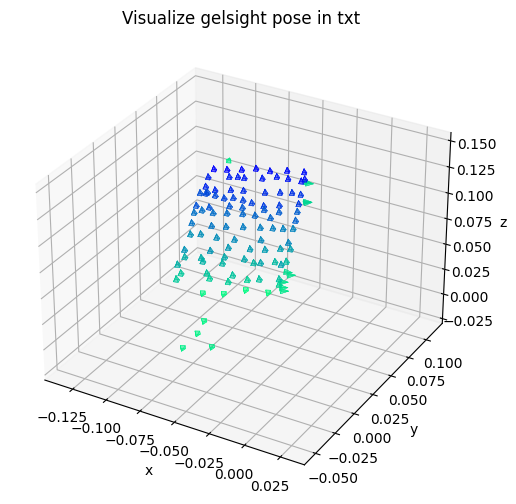

In [15]:
print(f"check T_gelsightinworld: {T_gelsightinworld.shape}") # [N, 4, 4]
visualize_cam_gelsight_poses_3D(T_camerainworld=None, T_gelsightinworld=T_gelsightinworld, plt_title="Visualize gelsight pose in txt", save_plot=True, show_plot=True, save_path=f"logs/visualize_gelsight_poses_txt_{obj_name}.png", focal_len_scaled=0.01)

In [7]:
raise ValueError("Stop here")

ValueError: Stop here